# Secondary Modelling : Res-net 50

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image

from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *
from glaucoma.helpers.glaucoma_helpers import *
from fastai.distributed import *


In [4]:
import warnings

warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')


In [18]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR /"train"

In [9]:
meta_df = pickle.load(open(DATA_DIR / "meta_df_v5.pkl",'rb'))

In [10]:
# as we can see some images here are different size

In [13]:
unzipped_files = parse_files(str(DATA_DIR / "unzipped"))

In [14]:
# split up unzipped files
unzipped_head, unzipped_tail = split_unzipped(unzipped_files)

## Modelling:

In [20]:
path_img = TRAIN_DIR


In [187]:
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_rotate= 10,flip_vert =True, max_lighting = 0.1) # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [22]:
#using smaller image size
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_lighting = 0.25) # or tfms=None if none are needed
size=(400,520) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [ ]:
data.show_batch(3, figsize=(10,10), hide_axis=False)


In [112]:
# Running a basic image net
learn = cnn_learner(data,models.resnet34, pretrained = True)

In [115]:
class L1LossFlat(nn.L1Loss):
#Mean Absolute Error Loss”
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [38]:
class MSELossFlat(nn.MSELoss): 
#“Same as `nn.MSELoss`, but flattens input and target.”
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [119]:
learn.data.batch_size = 128

In [116]:
learn.loss = L1LossFlat
learn.loss = MSELossFlat

In [106]:
learn.metrics =[accuracy,MSELossFlat]

In [107]:
#learn.unfreeze()

In [ ]:
learn.lr_find()

Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


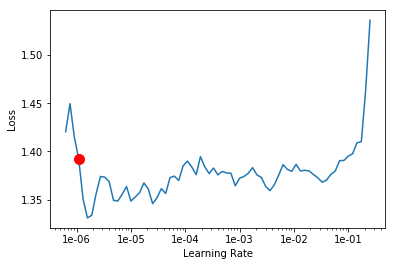

In [128]:
learn.recorder.plot(suggestion = True,)

## Training

In [129]:
min_grad_lr = 1.10E-06

In [130]:
learn.fit_one_cycle(3,min_grad_lr)

epoch,train_loss,valid_loss,time
0,1.397712,1.348037,26:17
1,1.385968,1.345513,23:12
2,1.388865,1.349640,23:13


In [124]:
learn.save("resnet_34_stage_1_e6_v2")

In [ ]:
learn.show_results()

## Testing

In [132]:
preds = learn.get_preds()

In [133]:
root_mean_squared_error(preds[0],preds[1])

tensor(1.1617)

In [134]:
mean_absolute_error(*preds)

tensor(0.8620)

In [135]:
exp_rmspe(*preds)

tensor(9.1563)

In [136]:
mean_squared_error(preds[0],preds[1])

tensor(1.3496)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [137]:
r2_score(*preds)

tensor(0.6089)

## Running inference on bad images

In [140]:
##Making test set:

In [147]:
# pull out 2000 bad images:

In [161]:
bad_images = list(meta_df[meta_df["grading"] == -1]["file_name"].unique())[:2000]

In [162]:
len(bad_images)

2000

In [165]:
# put them in test dir
for f in bad_images:
    try:
        idx = unzipped_tail.index(f)
    except:
        print(f)
    shutil.copy2(str(unzipped_files[idx]),DATA_DIR /"test")
    

In [166]:
# run inference on "bad images"

In [177]:
test_imgs = (DATA_DIR /"test").ls()
test_imgs.sort(key=lambda x: x.stem)
data.add_test(test_imgs) 
learn.data = data

In [169]:
preds = learn.get_preds(ds_type =DatasetType.Test)

[tensor([[3.2960],
         [3.6277],
         [3.3444],
         ...,
         [2.9193],
         [3.7142],
         [1.9742]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [194]:
learn.predict(img)

(FloatItem [3.29602], tensor([3.2960]), tensor([3.2960]))

In [ ]:
# Adding 

In [ ]:
good_vars =[]
for i in range(20):
    good_images = list(meta_df[meta_df["grading"] == i/2]["file_name"].unique())[:100]
    for file in good_images:
        idx = unzipped_tail.index(file)
        img =open_image(str(unzipped_files[idx]))
        preds = learn.predict_with_mc_dropout(img,n_times = 50)
        preds = [item[0].data[0] for item in preds]
        good_vars.append(np.var(preds))
    
        

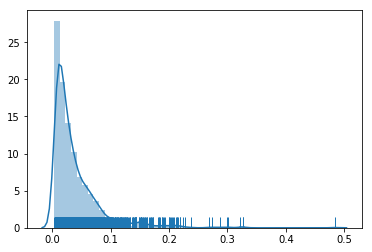

In [233]:
sns.distplot(good_vars,hist = True, rug = True)

In [219]:
bad_vars =[]
for file in bad_images:
    img =open_image(DATA_DIR /"test" / file )
    preds = learn.predict_with_mc_dropout(img,n_times = 50)
    preds = [item[0].data[0] for item in preds]
    bad_vars.append(np.var(preds))
    

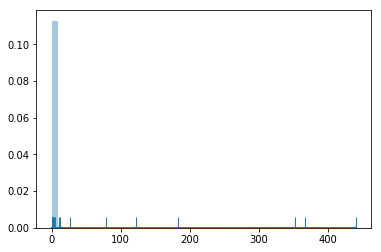

In [228]:
sns.distplot(bad_vars,hist = True, rug = True)

## Single rater training

This tests training on just single rater datasets, so there is no concordance issues within the data

In [23]:
jamie_images = meta_df[meta_df["grader"] == "jamie"]

In [24]:
JAMIE_DIR = DATA_DIR / "train_jamie"

In [ ]:
for rating in range(20):
    os.mkdir(JAMIE_DIR /str(rating/2))
    dir = str(JAMIE_DIR / str(rating/2))
    f_names = list(jamie_images[jamie_images['grading'] == rating/2]['file_name'])
    for f in f_names:
        try:
            idx = unzipped_tail.index(f)
        except:
            print(f)
        shutil.copy2(unzipped_files[idx],dir)
    print(rating/2," " ,len(f_names))

In [26]:
#using smaller image size
src = ImageList.from_folder(JAMIE_DIR).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_lighting = 0.25) # or tfms=None if none are needed
size=(400,520) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [ ]:
data.normalize()

In [161]:
# Running a basic image net
learn_jamie = cnn_learner(data,models.resnet50, pretrained = True, callback_fns = ShowGraph)

In [162]:
learn_jamie.data.batch_size = 64

In [163]:
#use both gpus
learn_jamie.model = torch.nn.DataParallel(learn_jamie.model)

In [164]:
#learn.loss = L1LossFlat
learn_jamie.loss = MSELossFlat

In [165]:
learn_jamie.metrics =[accuracy]

In [91]:
#learn.unfreeze()

In [131]:
learn_jamie.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.09E-02


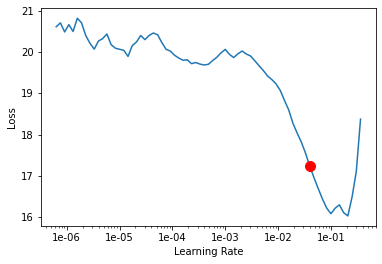

In [133]:
learn_jamie.recorder.plot(suggestion = True)

In [166]:
min_grad_lr = 3.98E-02

epoch,train_loss,valid_loss,accuracy,time
0,2.502863,1.802798,0.036187,07:59
1,2.108191,2.276827,0.036187,07:55
2,2.047731,1.709849,0.036187,07:55
3,1.906552,2.075018,0.036187,07:54
4,1.737004,1.686808,0.036187,07:54
5,1.745187,2.135669,0.036187,07:52
6,1.620519,1.457897,0.036187,07:51
7,1.416813,1.604705,0.036187,07:51
8,1.317514,2.075906,0.036187,07:51


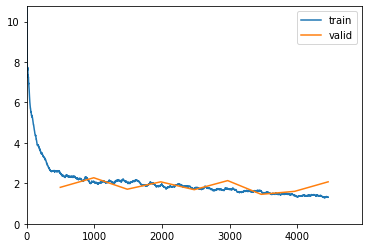

Better model found at epoch 0 with valid_loss value: 1.802797555923462.
Better model found at epoch 2 with valid_loss value: 1.7098489999771118.
Better model found at epoch 4 with valid_loss value: 1.6868083477020264.
Better model found at epoch 6 with valid_loss value: 1.4578967094421387.


In [ ]:
learn_jamie.fit_one_cycle(10,min_grad_lr,callbacks=[SaveModelCallback(learn_jamie,name = "res50_single_rater_best_heat_1")])

In [ ]:
learn_jamie.load("model_single_rater_e8")

In [ ]:
learn_jamie.load("single_rater_unfreeze_best_heat_3")

In [ ]:
#train and save best:

In [68]:
#unfreeze
learn_jamie.unfreeze()

In [80]:
learn_jamie.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 9.12E-06


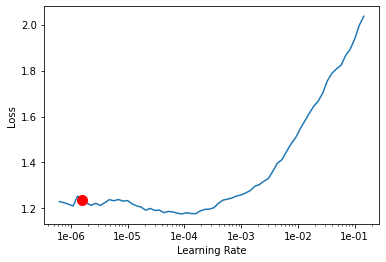

In [81]:
learn_jamie.recorder.plot(suggestion = True)

In [82]:
min_grad_lr = 1.58E-06

epoch,train_loss,valid_loss,accuracy,time
0,1.151548,1.179325,0.036187,07:50
1,1.190952,1.172829,0.036187,07:44
2,1.171369,1.166157,0.036187,07:44
3,1.168718,1.167824,0.036187,07:51
4,1.175857,1.168891,0.036187,07:50


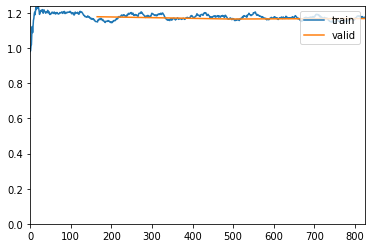

Better model found at epoch 0 with valid_loss value: 1.1793254613876343.
Better model found at epoch 1 with valid_loss value: 1.1728287935256958.
Better model found at epoch 2 with valid_loss value: 1.1661568880081177.


In [83]:
learn_jamie.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn_jamie,name = "single_rater_unfreeze_best_heat_3")])

### predictions

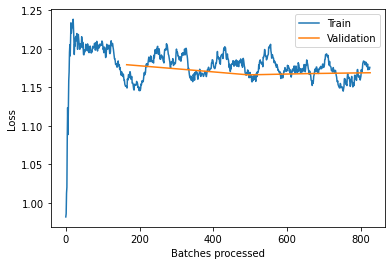

In [85]:
learn_jamie.recorder.plot_losses()

In [121]:
preds =learn_jamie.get_preds()

In [122]:
mean_squared_error(preds[0],preds[1])

tensor(1.1662)

In [123]:
root_mean_squared_error(preds[0],preds[1])

tensor(1.0799)

In [124]:
mean_absolute_error(*preds)

tensor(0.7763)

In [125]:
exp_rmspe(*preds)

tensor(7.4708)

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [126]:
r2_score(*preds)

tensor(0.6487)

## memory management

In [160]:
torch.cuda.empty_cache()

In [159]:
learn_jamie.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
